In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#load generator data
gds = {}
gds[2019] = pickle.load(open('Data/generator_data_short_WECC_2019.obj', 'rb'))
gds[2020] = pickle.load(open('Data/generator_data_short_WECC_2020.obj', 'rb'))

colorset = ['#CC6677', '#332288', '#DDCC77', '#117733', '#88CCEE', '#882255', '#44AA99', '#999933', '#AA4499']
'''Color list:
indigo, cyan, teal, green, sand, rose, wine, olive, purple
uncontrolled, color = colorset[0], 
mef normal all access, color = colorset[4], 
mef normal plugged, color = colorset[6]
aef all access, color = colorset[3], 
aef plugged, color = colorset[1]
mef cascade all access, color = colorset[5]
mef cascade plugged, color = colorset[8]
'''

path_string = '/Users/sonia/OneDrive - Stanford/GreenCharging_SharedResults/MEF/'
path_string_aef = '/Users/sonia/OneDrive - Stanford/GreenCharging_SharedResults/AEF/'
result_dates = ['20231207']

## Process data into g CO2 per kwh

In [20]:
def results_gperkwh_fxn_avg(numev_set, path_string, run_numbers, result_date, current_year = None, month=1):
    '''Function to calculate average g/kWh for each run number and number of EVs added'''
    if current_year == 2030:
        #use 2020 for uncontrolled data
        dpdf_year = '2020'
        #get reference baseline projected 2030 demand

        reference_df = pd.read_csv('Results/' +'2030_dpdf_'+'20220522'+ '.csv')

    #default = 2020
    else:
        dpdf_year = '2020'
        reference_df = pd.read_csv('Results/2020_dpdf_20220522.csv')

    if month == 1:
        time_period_string = '2020-01-01_to_2020-01-31'
    elif month == 7: 
        time_period_string = '2020-07-01_to_2020-07-31'

    results_gperkwh_avg = pd.DataFrame(index=numev_set, columns=['uncontrolled', 'uncontrolled_2s', 'varying_access', 'varying_plugged', 'varying_access_2s', 'varying_plugged_2s'])
    for num_evs in numev_set:
        results_gperkwh = pd.DataFrame(index=run_numbers, columns=['uncontrolled', 'varying_access', 'varying_plugged'])
        for run_number in run_numbers:
            df_total_uncontrolled = {}; df_uncontrolled_dpdf = {}
            df_controlled_dpdf = {'varying':{'access':{}, 'plugged':{}}}
            df_total_controlled = { 'varying':{'access':{}, 'plugged':{}}}
    
            #save uncontrolled demand data in df
            df_total_uncontrolled[num_evs] = pd.read_csv(path_string + str(num_evs)+'EVs_added/Uncontrolled/demand_run'+run_number+'_'+time_period_string+'_'+result_date+'.csv', index_col=0)
            
            df_total_uncontrolled[num_evs].datetime = pd.to_datetime(df_total_uncontrolled[num_evs].datetime)
            df_uncontrolled_dpdf[num_evs] = pd.read_csv(path_string +str(num_evs)+'EVs_added/Uncontrolled/results_'+dpdf_year+'_run'+run_number+'_'+time_period_string+'_dpdf_'+result_date+'.csv')
            df_uncontrolled_dpdf[num_evs].datetime = pd.to_datetime(df_uncontrolled_dpdf[num_evs].datetime)
            
            for signal1 in ['varying']:
                try: #if have both plugged and access saved
                    for signal2 in ['access', 'plugged']:
                        df_total_controlled[signal1][signal2][num_evs] = pd.read_csv(path_string +str(num_evs)+'EVs_added/Controlled_'+str(signal1)+'_allaccess_'+str(signal2)+'_series/demand_run'+run_number+'_'+time_period_string+'_'+result_date+'.csv', index_col=0)
                        df_total_controlled[signal1][signal2][num_evs].datetime = pd.to_datetime(df_total_controlled[signal1][signal2][num_evs].datetime)
                        df_controlled_dpdf[signal1][signal2][num_evs] = pd.read_csv(path_string+str(num_evs)+'EVs_added/Controlled_'+str(signal1)+'_allaccess_'+str(signal2)+'_series/results_'+dpdf_year+'_run'+run_number+'_'+time_period_string+'_dpdf_'+result_date+'.csv')
                        df_controlled_dpdf[signal1][signal2][num_evs].datetime = pd.to_datetime(df_controlled_dpdf[signal1][signal2][num_evs].datetime)
                except: #if don't have plugged and access saved
                    try:
                        for signal2 in ['access']:
                            df_total_controlled[signal1][signal2][num_evs] = pd.read_csv(path_string +str(num_evs)+'EVs_added/Controlled_'+str(signal1)+'_allaccess_'+str(signal2)+'_series/demand_run'+run_number+'_'+time_period_string+'_'+result_date+'.csv', index_col=0)
                            df_total_controlled[signal1][signal2][num_evs].datetime = pd.to_datetime(df_total_controlled[signal1][signal2][num_evs].datetime)
                            df_controlled_dpdf[signal1][signal2][num_evs] = pd.read_csv(path_string+str(num_evs)+'EVs_added/Controlled_'+str(signal1)+'_allaccess_'+str(signal2)+'_series/results_'+dpdf_year+'_run'+run_number+'_'+time_period_string+'_dpdf_'+result_date+'.csv')
                            df_controlled_dpdf[signal1][signal2][num_evs].datetime = pd.to_datetime(df_controlled_dpdf[signal1][signal2][num_evs].datetime)
                    except:
                        for signal2 in ['plugged']:
                            df_total_controlled[signal1][signal2][num_evs] = pd.read_csv(path_string +str(num_evs)+'EVs_added/Controlled_'+str(signal1)+'_allaccess_'+str(signal2)+'_series/demand_run'+run_number+'_'+time_period_string+'_'+result_date+'.csv', index_col=0)
                            df_total_controlled[signal1][signal2][num_evs].datetime = pd.to_datetime(df_total_controlled[signal1][signal2][num_evs].datetime)
                            df_controlled_dpdf[signal1][signal2][num_evs] = pd.read_csv(path_string+str(num_evs)+'EVs_added/Controlled_'+str(signal1)+'_allaccess_'+str(signal2)+'_series/results_'+dpdf_year+'_run'+run_number+'_'+time_period_string+'_dpdf_'+result_date+'.csv')
                            df_controlled_dpdf[signal1][signal2][num_evs].datetime = pd.to_datetime(df_controlled_dpdf[signal1][signal2][num_evs].datetime)

            #find dates to plot (inds)
            signal1 = 'varying'
            signal2 = 'access'
            try:
                dpdf_inds = df_uncontrolled_dpdf[num_evs][df_uncontrolled_dpdf[num_evs].datetime.dt.date.isin(df_total_controlled[signal1][signal2][num_evs].datetime.dt.date.unique())].index
            except:
                signal2 = 'plugged'
                dpdf_inds = df_uncontrolled_dpdf[num_evs][df_uncontrolled_dpdf[num_evs].datetime.dt.date.isin(df_total_controlled[signal1][signal2][num_evs].datetime.dt.date.unique())].index

            delta_co2 = df_uncontrolled_dpdf[num_evs].loc[dpdf_inds, 'co2_tot'].sum() - reference_df.loc[dpdf_inds, 'co2_tot'].sum()
            delta_demand = df_uncontrolled_dpdf[num_evs].loc[dpdf_inds, 'demand'].sum() - reference_df.loc[dpdf_inds, 'demand'].sum()


            results_gperkwh.loc[run_number, 'uncontrolled'] = delta_co2/delta_demand
            
            for signal1 in ['varying']:
                signal2_set = ['access', 'plugged']
                try:
                    for signal2 in signal2_set:
                        delta_co2 = df_controlled_dpdf[signal1][signal2][num_evs].loc[dpdf_inds, 'co2_tot'].sum() - reference_df.loc[dpdf_inds, 'co2_tot'].sum()
                        delta_demand = df_controlled_dpdf[signal1][signal2][num_evs].loc[dpdf_inds, 'demand'].sum() - reference_df.loc[dpdf_inds, 'demand'].sum()
                        results_gperkwh.loc[run_number, signal1+'_'+signal2] = delta_co2/delta_demand
                except:
                    try:
                        for signal2 in ['access']:
                            delta_co2 = df_controlled_dpdf[signal1][signal2][num_evs].loc[dpdf_inds, 'co2_tot'].sum() - reference_df.loc[dpdf_inds, 'co2_tot'].sum()
                            delta_demand = df_controlled_dpdf[signal1][signal2][num_evs].loc[dpdf_inds, 'demand'].sum() - reference_df.loc[dpdf_inds, 'demand'].sum()
                            results_gperkwh.loc[run_number, signal1+'_'+signal2] = delta_co2/delta_demand
                    except:
                        for signal2 in ['plugged']:
                            delta_co2 = df_controlled_dpdf[signal1][signal2][num_evs].loc[dpdf_inds, 'co2_tot'].sum() - reference_df.loc[dpdf_inds, 'co2_tot'].sum()
                            delta_demand = df_controlled_dpdf[signal1][signal2][num_evs].loc[dpdf_inds, 'demand'].sum() - reference_df.loc[dpdf_inds, 'demand'].sum()
                            results_gperkwh.loc[run_number, signal1+'_'+signal2] = delta_co2/delta_demand

        results_gperkwh_avg.loc[num_evs, 'uncontrolled'] = np.average(results_gperkwh.loc[:, 'uncontrolled'])
        results_gperkwh_avg.loc[num_evs, 'varying_access'] = np.average(results_gperkwh.loc[:, 'varying_access'])
        results_gperkwh_avg.loc[num_evs, 'varying_plugged'] = np.average(results_gperkwh.loc[:, 'varying_plugged'])
        results_gperkwh_avg.loc[num_evs, 'uncontrolled_2s'] = 2 * np.std(results_gperkwh.loc[:, 'uncontrolled'])
        results_gperkwh_avg.loc[num_evs, 'varying_access_2s'] = 2 * np.std(results_gperkwh.loc[:, 'varying_access'])
        results_gperkwh_avg.loc[num_evs, 'varying_plugged_2s'] = 2 * np.std(results_gperkwh.loc[:, 'varying_plugged'])
        
    return results_gperkwh_avg

In [21]:
def plot_emissions_bar(save_str, results_g, results_g_aef, added_EVs):
    added_EVs_list = []
    for num in added_EVs:
        added_EVs_list.append(str(num))

    control_types = {
        'Uncontrolled': results_g.uncontrolled, 
        'MEF': results_g.varying_plugged,
        'AEF': results_g_aef.varying_plugged,
    }

    control_stddev = {
        'Uncontrolled': results_g.uncontrolled_2s, 
        'MEF': results_g.varying_plugged_2s,
        'AEF': results_g_aef.varying_plugged_2s,
    }

    x = np.arange(len(added_EVs_list))  # the label locations

    width = 0.18  # the width of the bars
    multiplier = 0
    hatches = ['', '/', '-']

    fig, ax = plt.subplots(1,1, figsize=(11.5,4))
    colorset_1 = [colorset[0] , colorset[6] , colorset[1] , ]

    for attribute, measurement in control_types.items():
        offset = width * multiplier 
        rects = ax.bar(x + offset, measurement , width, label=attribute, color = colorset_1[multiplier], hatch = hatches[multiplier], yerr = control_stddev[attribute], capsize=5, edgecolor='black')
        ax.bar_label(rects, labels=[round(float(co2 )) for co2 in measurement ], fontsize=13, padding=3)
        multiplier += 1
    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Added CO$_2$ Emissions [kg/MWh]', fontsize = 15
                  )
    ax.set_xlabel('Number of Added EVs', fontsize = 16)
    ax.tick_params(axis='y', which='major', labelsize=16)
    ax.tick_params(axis='x', which='major', labelsize=16)
    ax.set_xticks(x + width  , added_EVs_list)
    ax.legend(ncols=3, fontsize=13.9, loc='upper left')
    ax.set_ylim([0,max(results_g.uncontrolled)*1.4  ])


    plt.savefig(save_str + '1c_bar.pdf', bbox_inches='tight')
    plt.show()
    return

        uncontrolled uncontrolled_2s varying_access varying_plugged  \
100000    562.661764        0.333669     486.270345      463.889565   
1000000   550.687205         0.08056     556.736257      531.917161   
2000000   546.088149         0.08264     566.106601      551.305117   

        varying_access_2s varying_plugged_2s  
100000           9.471078           2.197264  
1000000          1.378708           1.131254  
2000000           0.87876           1.364519  


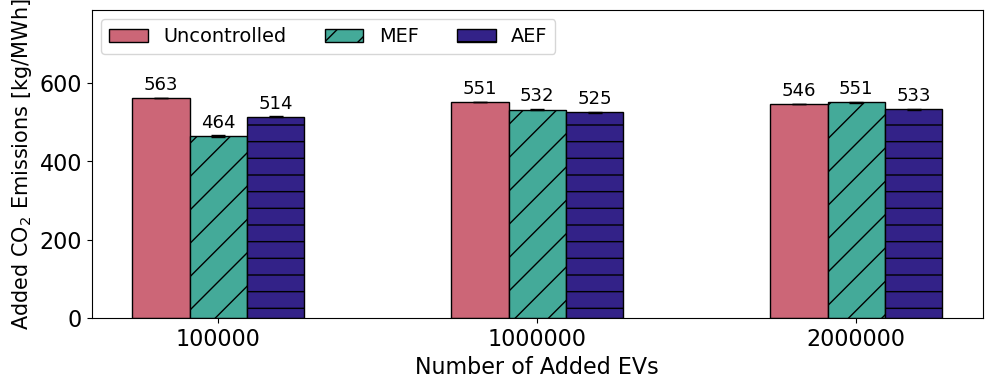

In [22]:

save_str = 'Added_Emissions/'

run_nums = [str(i) for i in range(15)]

added_EVs = [100000, 1000000, 2000000]

#get SR-MEF

results_g = results_gperkwh_fxn_avg(added_EVs, path_string, run_nums, result_dates[0])

#get AEF
results_g_aef = results_gperkwh_fxn_avg(added_EVs, path_string_aef, run_nums, result_dates[0])

print(results_g)
plot_emissions_bar(save_str, results_g, results_g_aef, added_EVs)